In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install reproject

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import matplotlib.patches as patches
import pandas as pd
from astropy.visualization import simple_norm
from astropy import wcs
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
from matplotlib.transforms import Bbox
from astropy.io import ascii
from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord
from radio_beam import Beam
from astropy.io import fits
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve
from astropy.convolution import convolve_fft
from reproject import reproject_interp
import cv2

In [3]:
# high resolution files
highres_file ='/orange/adamginsburg/w51/w51-alma-longbaseline/FITS/W51n_cont_uniform.image.tt0.pbcor.fits'
hdu_highres = fits.open(highres_file)
hdu_highres.info()
highres = hdu_highres[0].data
highres = np.squeeze(highres)
header_high = hdu_highres['PRIMARY'].header
hdu_highres.close()
wcs_high = wcs.WCS(header_high)
beam_high = Beam.from_fits_header(header_high)
print(beam_high)
highres = highres/beam_high.sr

Filename: /orange/adamginsburg/w51/w51-alma-longbaseline/FITS/W51n_cont_uniform.image.tt0.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (5120, 5120)   float32   
Beam: BMAJ=0.0257846564054484 arcsec BMIN=0.017433758825064 arcsec BPA=-43.38716125488 deg


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
# Low resolution files
lowres_file = "/orange/adamginsburg/w51/ALMA-IMF_W51/W51-IRS2/B6/bsens/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_bsens_12M_robust0_selfcal8_finaliter.image.tt0.pbcor.fits"
hdu_lowres = fits.open(lowres_file)
hdu_lowres.info()
lowres = hdu_lowres[0].data
lowres = np.squeeze(lowres)
header_low = hdu_lowres['PRIMARY'].header
hdu_lowres.close()
wcs_low = wcs.WCS(header_low)
beam_low = Beam.from_fits_header(header_low)
print(beam_low)
lowres = lowres/beam_low.sr

Filename: /orange/adamginsburg/w51/ALMA-IMF_W51/W51-IRS2/B6/bsens/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_bsens_12M_robust0_selfcal8_finaliter.image.tt0.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      88   (1120, 1120, 1, 1)   float32   
Beam: BMAJ=0.50521850585928 arcsec BMIN=0.43920379877076 arcsec BPA=-25.74533081055 deg


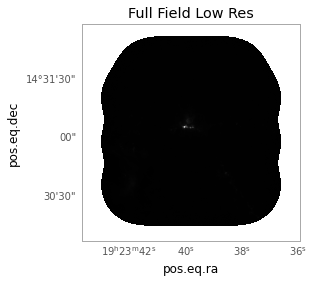

In [5]:
# Plot of low resolution image
norm_full_low=simple_norm(lowres.value, stretch='asinh', min_percent=0.01, max_percent=99.99)
ax = plt.subplot(projection=wcs_low.celestial)
plt.imshow(lowres.value, cmap='gray', interpolation="nearest", origin="lower")
ax.grid(False)
ax.set_title('Full Field Low Res')
plt.show()

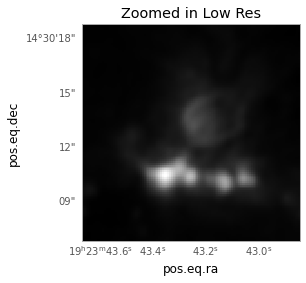

In [6]:
norm_zoom_low = simple_norm(lowres[550:670, 480:600].value, stretch='asinh', min_percent=0.01, max_percent=99.99)
ax = plt.subplot(projection=wcs_low[550:670, 480:600].celestial)
plt.imshow(lowres[550:670, 480:600].value, cmap='gray', interpolation="nearest", origin="lower", norm=norm_zoom_low)
ax.grid(False)
ax.set_title('Zoomed in Low Res')
plt.show()

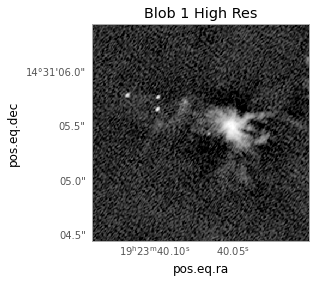

In [7]:
highres_blob1 = highres[2350:2750, 2300:2700]
norm_highres_blob1 = simple_norm(highres_blob1, stretch='asinh', min_percent=5, max_percent=99.99)
ax = plt.subplot(projection=wcs_high.celestial[2350:2750, 2300:2700])
ax.imshow(highres_blob1, cmap='gray', interpolation="nearest", origin="lower", norm=norm_highres_blob1)
ax.grid(False)
ax.set_title('Blob 1 High Res')
plt.show()

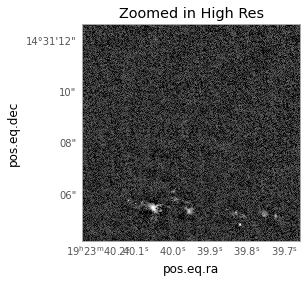

In [8]:
zoom_high = highres[2300:4000, 2000:3700]
norm_zoom_high = simple_norm(zoom_high, stretch='asinh', min_percent=5, max_percent=99.99)
ax = plt.subplot(projection=wcs_high.celestial[2300:4000, 2000:3700])
ax.imshow(zoom_high, cmap='gray', interpolation="nearest", origin="lower", norm=norm_zoom_high)
ax.grid(False)
ax.set_title('Zoomed in High Res')
plt.show()

In [9]:
# convolving to blur the high resolution
deconv_beam = beam_low.deconvolve(beam_high)
pix_scale = wcs.utils.proj_plane_pixel_scales(wcs_high)[0]*u.deg
gauss_kern = deconv_beam.as_kernel(pix_scale)
print(deconv_beam, pix_scale.to(u.arcsec))
gauss_kern.model

Beam: BMAJ=0.5045931179200723 arcsec BMIN=0.43881968553591627 arcsec BPA=-25.649083399903933 deg 0.0050000000000004 arcsec


<Gaussian2D(amplitude=0.00009964, x_mean=0., y_mean=0., x_stddev=42.85619353, y_stddev=37.26991253, theta=1.12313537)>

In [10]:
wcs_high.wcs.cunit

['deg', 'deg']

In [11]:
# bluring the high resolution of blob 1
blob1_conv = convolve(highres_blob1, gauss_kern)

In [12]:
zoom_conv = convolve_fft(zoom_high, gauss_kern)

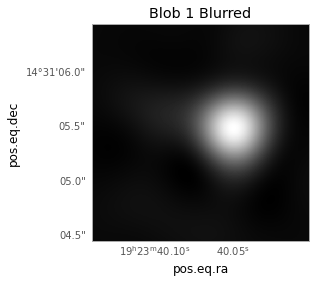

In [13]:
ax = plt.subplot(projection=wcs_high.celestial[2350:2750, 2300:2700])
ax.imshow(blob1_conv,  cmap='gray', interpolation="nearest", origin="lower")
ax.grid(False)
ax.set_title('Blob 1 Blurred')
plt.show()

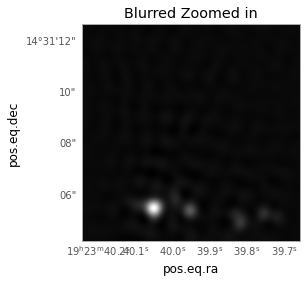

In [14]:
ax = plt.subplot(projection=wcs_high.celestial[2300:4000, 2000:3700])
ax.grid(False)
plt.imshow(zoom_conv, cmap='gray', interpolation="nearest", origin="lower")
ax.set_title('Blurred Zoomed in')
plt.show()

In [15]:
array_zoom, footprint1 = reproject_interp((lowres, wcs_low.celestial), wcs_high.celestial[2300:4000, 2000:3700], shape_out=zoom_conv.shape)

In [16]:
array_blob1, footprint2 = reproject_interp((lowres, wcs_low.celestial), wcs_high.celestial[2350:2750, 2300:2700], shape_out=blob1_conv.shape)

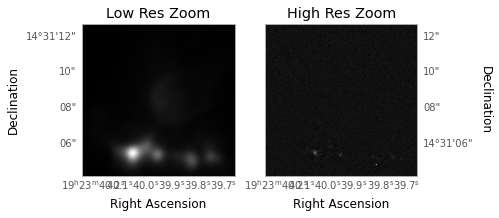

In [17]:
ax1 = plt.subplot(1,2,1, projection=wcs_high.celestial[2300:4000, 2000:3700])
ax1.imshow(array_zoom, cmap='gray', interpolation="nearest", origin="lower")
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Low Res Zoom')
ax1.grid(False)

ax2 = plt.subplot(1,2,2, projection=wcs_high.celestial[2300:4000, 2000:3700])
ax2.imshow(zoom_high.value, cmap='gray', interpolation="nearest", origin="lower")
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('High Res Zoom')
ax2.grid(False)
plt.show()

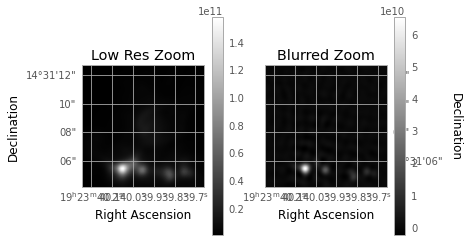

In [18]:
ax1 = plt.subplot(1,2,1, projection=wcs_high.celestial[2300:4000, 2000:3700])
zoom1=ax1.imshow(array_zoom, cmap='gray', interpolation="nearest", origin="lower")
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Low Res Zoom')
# ax1.grid(False)
plt.colorbar(mappable=zoom1)

ax2 = plt.subplot(1,2,2, projection=wcs_high.celestial[2300:4000, 2000:3700])
zoom2=ax2.imshow(zoom_conv, cmap='gray', interpolation="nearest", origin="lower")
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('Blurred Zoom')
# ax2.grid(False)
plt.colorbar(mappable=zoom2)
plt.show()

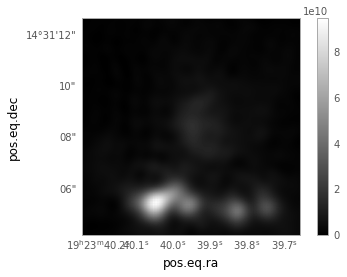

In [19]:
zoom_diff = array_zoom - zoom_conv
ax = plt.subplot(projection=wcs_high.celestial[2300:4000, 2000:3700])
ax.grid(False)
plt.imshow(zoom_diff, cmap='gray', interpolation="nearest", origin="lower")
plt.colorbar()
plt.show()

In [20]:
len(wcs_low.wcs.cdelt)

4